In [93]:
# !pip install gensim==4.2.0

In [19]:
import gensim
import pickle
import pandas as pd
import numpy as np

from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout 
from keras.layers import LSTM, Embedding

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

from gensim.models import Word2Vec

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

In [95]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# We might have to change the following
config = {
    "learning_rate": 0.001,
    "epochs": 3, 
    "batch_size": 70,
    "test_p": 0.2,
    "val_p": 0.1,
    # "LSTM_layer": [50, 100],
    # "Dropout_layer": [0.15, 0.2],
    # "activation": 'softmax',
    ##################### SAVE FOR LIVE DEMO #############################
    "model_path": "model/2c_model.h5",
    "tokenizer_path": "model/2c_tokenizer.pickle",
    "data_path": "model/2c_data.csv",
}

In [41]:
class LSTM_model:
    def __init__(self, path):
        self.path = path # Path to the dataset
        self.data = pd.DataFrame() # Dataframe to store the dataset
        self.tokenizer = Tokenizer(num_words=None, split=' ') # Tokenizer to tokenize the text

        self.context_window = 5 # Context window size
        self.w2v_feature_vector = []
        self.vocabulary_size = 0
        self.vocabulary = []

        self.jokes_to_numerical = []
        self.model = None
        self.word_vec = {}


    def read_dataset(self):
        """
        Reads the dataset from the given path.
        """
        ret = pd.read_csv(self.path)
        ret.drop(columns=['Unnamed: 0'], inplace=True)

        self.data = ret


    def w2v_model(self, max_length):
        """
        Splits the data into train and validation sets.
        Constructs the word2vec model. (Feature vector)
        """
        X = self.data['tokens']
        y = self.data['funny']

        print("X shape: ", X.shape)
        print("y shape: ", y.shape)
        # split the data into train and validation sets and make them random
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

        w2v_model = Word2Vec(X_train, vector_size=max_length, min_count=1, window=self.context_window)

        w2v_model.train(X_train, total_examples=len(X_train), epochs=10)

        vocab = w2v_model.wv.index_to_key
        print("Vocabulary size: ", len(vocab))


        for word in vocab:
            self.word_vec[word] = w2v_model.wv.get_vector(word)


    def LSTM_model(self, max_length):
        """
        Constructs the LSTM model.
        """
        # Create a padded sequence of the joke
        tokeniser = Tokenizer()
        tokeniser.fit_on_texts(self.data['clean_text'])
        vocab_size = len(tokeniser.word_index) + 1
        print("Vocabulary size: ", vocab_size)

        # pad the sequences to the same length
        ret = tokeniser.texts_to_sequences(self.data['clean_text'])

        data_padded = pad_sequences(ret, maxlen=max_length) #, padding='post')
        print("Data padded shape: ", data_padded.shape)

        # Create the embeddings matrix
        embedding_matrix = np.zeros((vocab_size, max_length))
        for word, i in tokeniser.word_index.items():
            embedding_vector = self.word_vec.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector


        Y = self.data['funny']
        x_train, x_test, y_train, y_test = train_test_split(data_padded, 
                                                            Y, test_size=config['test_p'], 
                                                            random_state=42)


        # Create the model
        # LSTM Model with 2 Layers.
        self.model = Sequential()
        self.model.add(Embedding(input_dim=vocab_size, output_dim=max_length, input_length=max_length, 
                            weights=[embedding_matrix], trainable=False))
        self.model.add(LSTM(units=50, return_sequences=True))
        self.model.add(LSTM(units=10))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(units=1, activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model.summary()
        self.model.fit(x_train, y_train,epochs=config['epochs'], batch_size=config['batch_size'], verbose='auto', validation_split=config['val_p'])

        self.model.save(config['model_path']) # save the model
        self.evaluate_model(x_test, y_test, max_length) # evaluate the model


    def evaluate_model(self, X_test, y_test, max_length):
        """
        Evaluates the model. (Precision, recall, f1 score)
        """
        scores = self.model.evaluate(X_test, y_test)
        print("Accuracy: %.2f%%" % (scores[1] * 100))

        # Print Precision and Recall
        y_pred = self.model.predict(X_test)
        y_pred = np.round(y_pred)

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print("Precision: %.2f%%" % (precision * 100))
        print("Recall: %.2f%%" % (recall * 100))
        print("F1-Score: %.2f%%" % (f1 * 100))

        ##################################### PLOTTING #####################################
        # Binary classification plotting 
        # Plotting the confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10,10))
        sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square=True, cmap='Blues_r')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.title('Confusion Matrix')
        plt.show()


        # plot how many jokes are predicted as funny
        plt.figure(figsize=(10,10))
        sns.set(font_scale=1.4)
        sns.set_style("whitegrid")
        sns.distplot(y_test, kde=False, bins=10, label='Actual')
        sns.distplot(y_pred, kde=False, bins=10, label='Predicted')
        plt.legend()
        plt.title('Binary Classification Accuracy')
        plt.show()
        ######################################################################################


        self.save_data(max_length, scores, precision, recall, f1) # Save the model data for live demo.


    def save_data(self, max_length, accuracy, precision, recall, f1):
        """
        Saves the data.
        """
        # Add in dataframe master_df max_len, accuracy, precision, recall, f1-score
        ret = pd.DataFrame(columns=['max_len', 'accuracy', 'precision', 'recall', 'f1-score'])
        ret.loc[0] = [max_length, accuracy, precision, recall, f1]
        ret.to_csv(config['data_path'])
        
        # save the tokenizer
        with open(config['tokenizer_path'], 'wb') as handle:
            pickle.dump(self.tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


### Read Data and pre-process it.

In [42]:
# SETTINGS for local machine - change this for Goolg Colab
path = "dataset/final_jokes(2918).csv"
# path = "dataset/final_jokes_and_facts(2918).csv"

joke_model = LSTM_model(path)
joke_model.read_dataset()

max_length_joke = joke_model.data['token_count'].max()
# joke_model.get_vocabulary()

### Construct the word2vec embedding vector and train the LSTM model

X shape:  (2918,)
y shape:  (2918,)
Vocabulary size:  73
Vocabulary size:  5777
Data padded shape:  (2918, 134)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 134, 134)          774118    
                                                                 
 lstm_22 (LSTM)              (None, 134, 50)           37000     
                                                                 
 lstm_23 (LSTM)              (None, 10)                2440      
                                                                 
 dropout_11 (Dropout)        (None, 10)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 813,569
Trainable params: 39,451
Non-trainable params: 774,

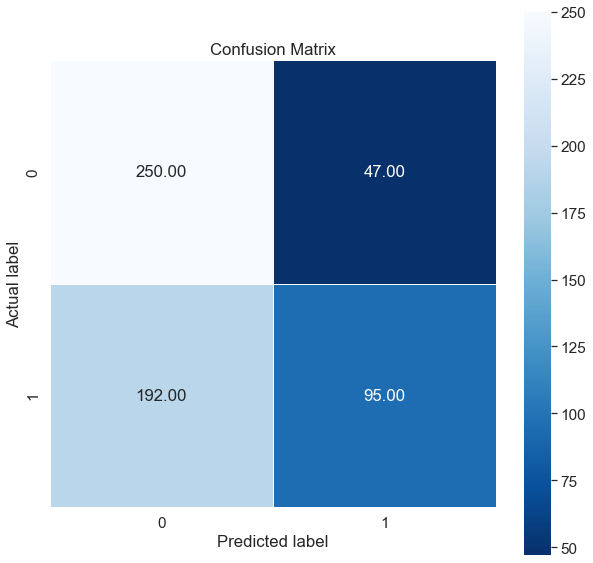

c:\Users\paulc\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


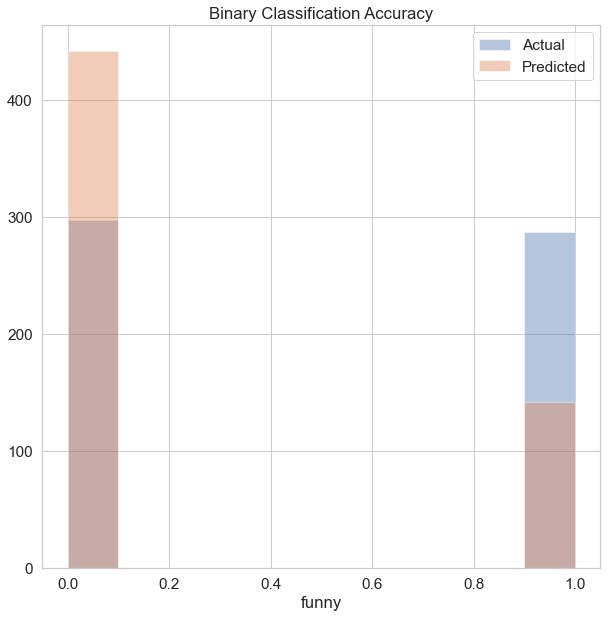

In [43]:
joke_model.w2v_model(max_length_joke)
joke_model.LSTM_model(max_length_joke)